1. Load Data

In [1]:
import os
import pandas as pd
from sklearn import preprocessing

# multiclass
# filename = 'original_label_syslog.csv'
filename = 'preprocess_original_label_syslog.csv'

# binary
# filename = 'label_syslog_structured.csv'

folder = os.path.join("..", "0_dataset", "syslog")
models_folder = "models_logs"
data_type = 'System Logs'


df = pd.read_csv(os.path.join(folder, filename))
df = df.loc[:, ['EventTemplate', 'Label']]

print(df.info)


# build labeling map
label_original = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))


X = df['EventTemplate']
X = X.to_numpy()
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)

<bound method DataFrame.info of                                             EventTemplate  Label
0                            "GET <*> <*> 200 <*> "-" <*>      0
1                            "GET <*> <*> 200 <*> "-" <*>      0
2                            "GET <*> <*> 200 <*> "-" <*>      0
3                            "GET <*> <*> 200 <*> "-" <*>      0
4                            "GET <*> <*> 200 <*> "-" <*>      0
...                                                   ...    ...
116146  "GET /chat/read_log.php HTTP/1.1" 404 <*> "abo...      1
116147       doit: getaddrinfo: Name or service not known      1
116148                             connect from <*> (<*>)      1
116149  "GET /chat/read_log.php HTTP/1.1" 404 <*> "abo...      1
116150  localhost (<*>[<*>]) - USER <*> Login successful.      1

[116151 rows x 2 columns]>


2. Define the Models

In [2]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention


if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is not available')


max_seq_length = 40
vocab_size = 500


dl_models = {}
# deep learning
def build_BERT():
    preprocessing_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
    
    text_input = layers.Input(shape=(), dtype=tf.string)
    encoder_inputs = preprocessing_layer(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output'] # include pooled_output & sequence_output
    net = layers.Dropout(0.3)(net)
    net = layers.Dense(len(label_original), activation='softmax')(net)
    
    return tf.keras.Model(text_input, net, name='BERT')

dl_models['RNN'] = tf.keras.Sequential([
    layers.Embedding(vocab_size, input_length=max_seq_length, output_dim=64),
    layers.SimpleRNN(64, return_sequences=True, dropout=0.3),
    SeqSelfAttention(64, attention_activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(len(label_original), activation='softmax'),
], name='RNN')
dl_models['LSTM'] = tf.keras.Sequential([
    layers.Embedding(vocab_size, input_length=max_seq_length, output_dim=64),
    layers.LSTM(64, return_sequences=True, dropout=0.3),
    SeqSelfAttention(64, attention_activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(len(label_original), activation='softmax'),
], name='LSTM')
dl_models['Bi-LSTM'] = tf.keras.Sequential([
    layers.Embedding(vocab_size, input_length=max_seq_length, output_dim=64),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3)),
    SeqSelfAttention(64, attention_activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(len(label_original), activation='softmax'),
], name='Bi-LSTM')
dl_models['GRU'] = tf.keras.Sequential([
    layers.Embedding(vocab_size, input_length=max_seq_length, output_dim=64),
    layers.GRU(64, return_sequences=True, dropout=0.3),
    SeqSelfAttention(64, attention_activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(len(label_original), activation='softmax'),
], name='GRU')
dl_models['Bi-GRU'] = tf.keras.Sequential([
    layers.Embedding(vocab_size, input_length=max_seq_length, output_dim=64),
    layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.3)),
    SeqSelfAttention(64, attention_activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(len(label_original), activation='softmax'),
], name='Bi-GRU')


bert_models = {}
bert_models['BERT'] = build_BERT()

for name in dl_models:
    dl_models[name].summary()
for name in bert_models:
    bert_models[name].summary()

GPU is available


c:\Users\user\anaconda3\envs\lab\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            32000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 40, 64)            8256      
                                                                 
 seq_self_attention (SeqSelf  (None, 40, 64)           8321      
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 17)                1105      
                                                                 
Total params: 49,682
Trainable params: 49,682
Non-trainable par

3. bert training, testing

In [3]:
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from official.nlp import optimization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from keras_self_attention import SeqSelfAttention
import math
import pickle


epochs = 10
batch_size = 16
lr = 2e-5 # 5e-4, 2e-5, 3e-5
random_seed = 42


# text preprocessing
tokenizer_filename = os.path.join(models_folder, 'tokenizer')
if os.path.exists(tokenizer_filename):
    tokenizer = pickle.load(open(tokenizer_filename, 'rb'))
else:
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(X)
    pickle.dump(tokenizer, open(tokenizer_filename, 'wb'))
# X_tokenized = tokenizer.texts_to_sequences(X)
# X_tokenized = pad_sequences(X_tokenized, maxlen=max_seq_length)


# training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_train_tokenized = pad_sequences(X_train_tokenized, maxlen=max_seq_length)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_test_tokenized = pad_sequences(X_test_tokenized, maxlen=max_seq_length)
# X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print("original labels:{}".format(label_original))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))


# train_steps = math.ceil(len(X_train) / batch_size)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    # num_train_steps=train_steps,
    # num_warmup_steps=int(0.1*train_steps),
    # optimizer_type='adamw',
    name='adam'
)
# earlystop_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.0001,
#     patience=10,
#     verbose=1,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=True,
# )
evaluation = {}
for name in dl_models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
for name in bert_models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
    
for name, model in dl_models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name + '.h5')
    if os.path.exists(model_filename): # load the model from disk
        model = tf.keras.models.load_model(model_filename, custom_objects=SeqSelfAttention.get_custom_objects())
    else:
        model.compile(
            loss='sparse_categorical_crossentropy', 
            optimizer=optimizer, 
            metrics=['sparse_categorical_accuracy']
        )
        model.fit(
            X_train_tokenized, y_train, 
            batch_size=batch_size, epochs=epochs, 
            validation_data=(X_test_tokenized, y_test)
        )
        model.save(model_filename, save_format='h5')
    y_hat = model.predict(X_test_tokenized)
    y_hat = np.argmax(y_hat, axis=1) # turn one-hot format to label
    end_time = time.time()
    print("DL model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))

for name, model in bert_models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name + '.h5')
    if os.path.exists(model_filename): # load the model from disk
        model = tf.keras.models.load_model(model_filename, custom_objects={'KerasLayer': hub.KerasLayer})
    else:
        model.compile(
            loss='sparse_categorical_crossentropy', 
            optimizer=optimizer, 
            metrics=['sparse_categorical_accuracy']
        )
        model.fit(
            X_train, y_train, 
            batch_size=batch_size, epochs=epochs, 
            validation_data=(X_test, y_test)
        )
        model.save(model_filename, save_format='h5')
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1) # turn one-hot format to label
    end_time = time.time()
    print("DL model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))


original labels:[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
X_train:92920, y_train:92920
726/726 [==============================] - 7s 8ms/step
DL model: RNN 
execution time: 7.05



c:\Users\user\anaconda3\envs\lab\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


726/726 [==============================] - 3s 3ms/step
DL model: LSTM 
execution time: 3.38



c:\Users\user\anaconda3\envs\lab\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


726/726 [==============================] - 3s 3ms/step
DL model: Bi-LSTM 
execution time: 3.36



c:\Users\user\anaconda3\envs\lab\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


726/726 [==============================] - 2s 2ms/step
DL model: GRU 
execution time: 2.10



c:\Users\user\anaconda3\envs\lab\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


726/726 [==============================] - 2s 3ms/step
DL model: Bi-GRU 
execution time: 2.82

Epoch 1/10
5808/5808 [==============================] - 1877s 322ms/step - loss: 1.9654 - sparse_categorical_accuracy: 0.4682 - val_loss: 1.9211 - val_sparse_categorical_accuracy: 0.4732
Epoch 2/10
5808/5808 [==============================] - 1864s 321ms/step - loss: 1.9392 - sparse_categorical_accuracy: 0.4699 - val_loss: 1.9066 - val_sparse_categorical_accuracy: 0.4797
Epoch 3/10
5808/5808 [==============================] - 1823s 314ms/step - loss: 1.9331 - sparse_categorical_accuracy: 0.4703 - val_loss: 1.9072 - val_sparse_categorical_accuracy: 0.4780
Epoch 4/10
5808/5808 [==============================] - 1858s 320ms/step - loss: 1.9306 - sparse_categorical_accuracy: 0.4707 - val_loss: 1.9120 - val_sparse_categorical_accuracy: 0.4785
Epoch 5/10
5808/5808 [==============================] - 1866s 321ms/step - loss: 1.9287 - sparse_categorical_accuracy: 0.4705 - val_loss: 1.9057 - val_sparse

4. Show the model evalution result (F1 score)

In [4]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math

def round_off(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(round_off(mean(value), 3))

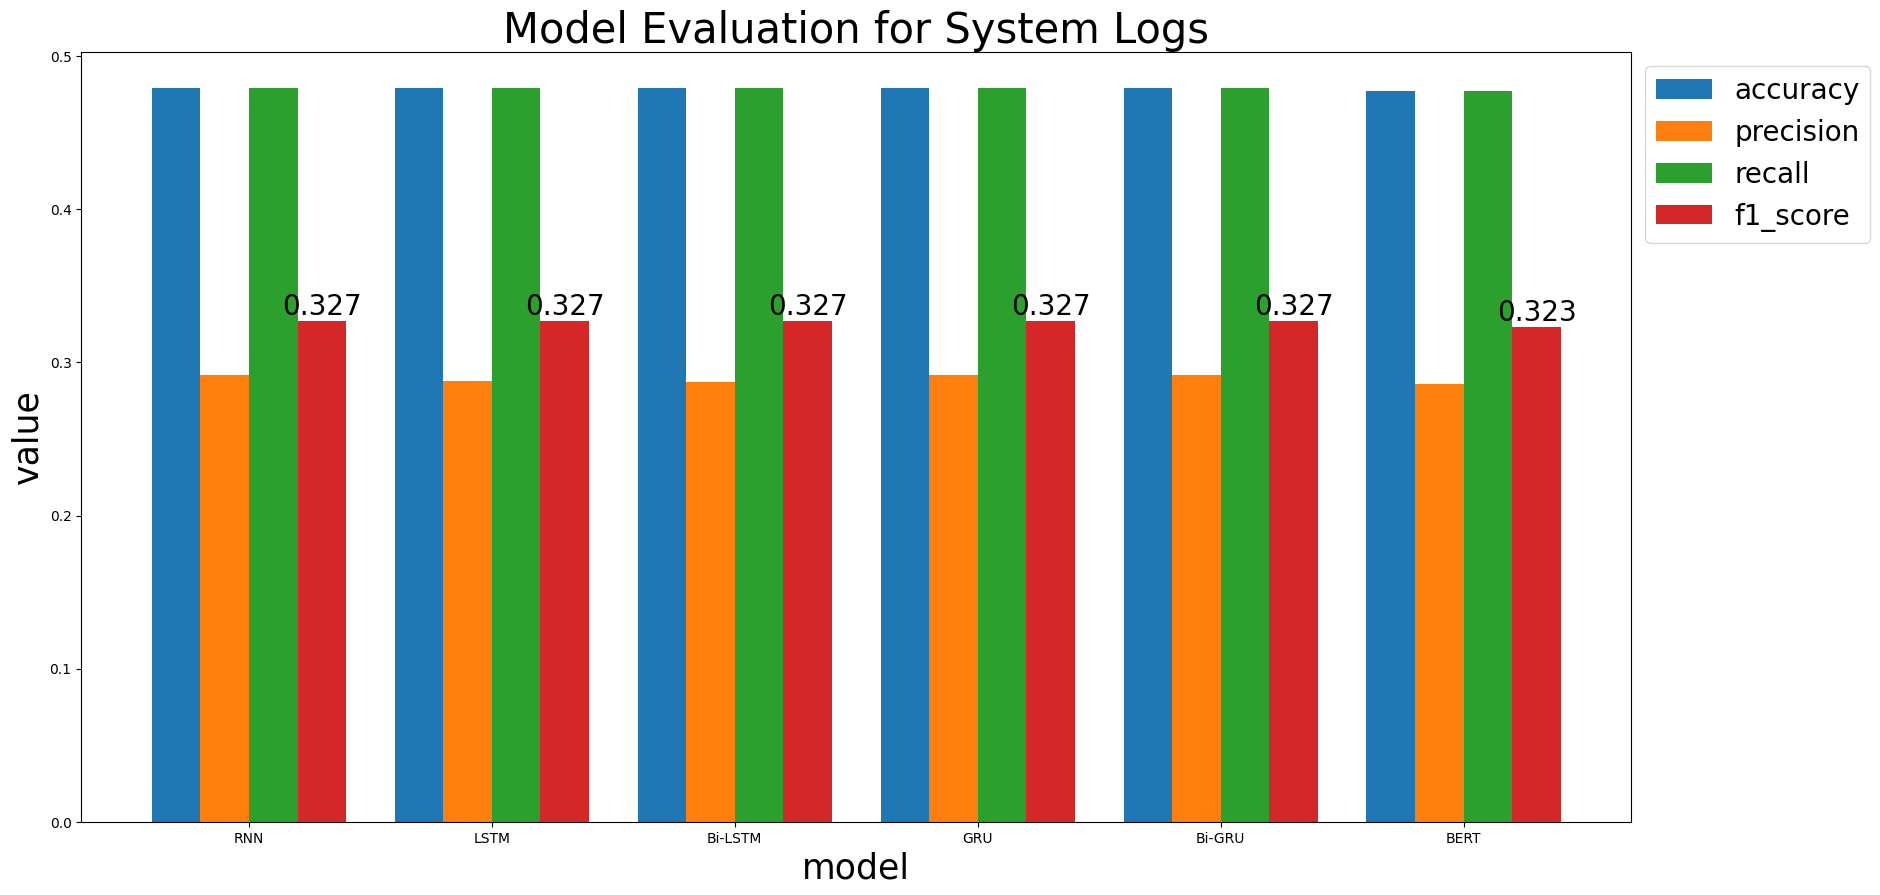

In [5]:
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=25)
plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 20,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.show()

5. train system logs model

726/726 [==============================] - 161s 220ms/step


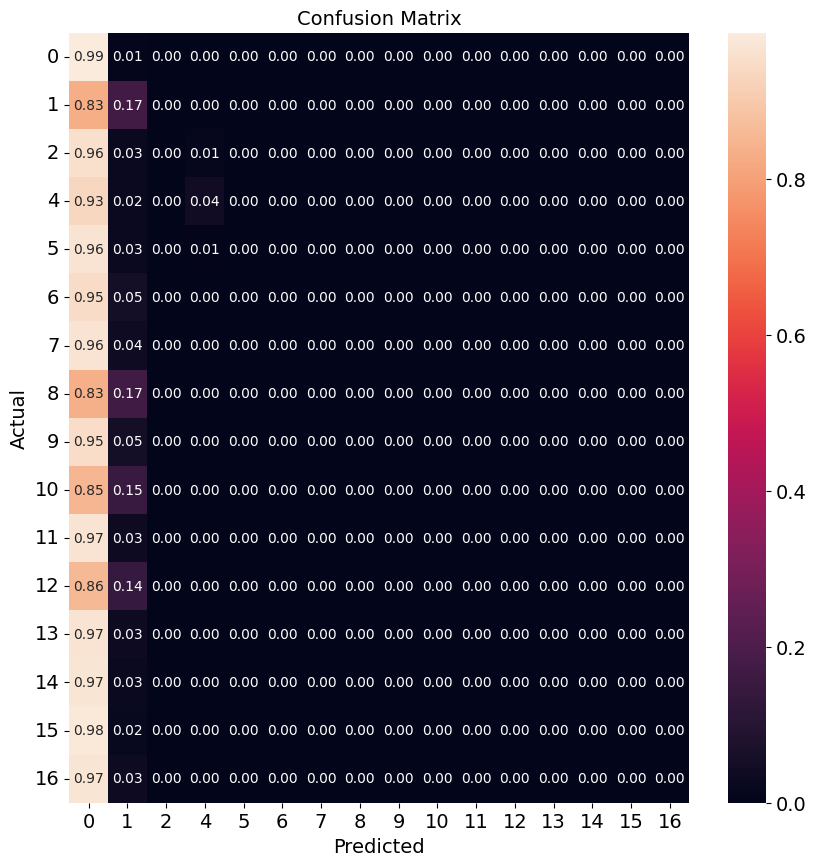

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

name = 'BERT.h5'
model_filename = os.path.join(models_folder, name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = sorted(np.unique(np.array(y_test)))
model = tf.keras.models.load_model(model_filename, custom_objects={'KerasLayer': hub.KerasLayer})
# model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)
y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)